Initialize the data

In [45]:
def load_historical_data():
    import MetaTrader5 as mt5
    from datetime import datetime, timedelta
    import time
    import pandas as pd
    #those imports are here because we did not do it fo be automatized we just initialize on one run otherwise we need to adjust
    m5=mt5.initialize()
    now = datetime.now()
    day, month, year = now.day, now.month, now.year
    current_date = datetime(year, month, day)
    from_date = datetime(2018, 10, 11)
    new_date = current_date + timedelta(days=5)
    #same dates and this logic should be outisde of the def here just for the test puposes

    # Load base timeframe - hard coded for btc we can adjust to provide time frame symbol and start end date dynamically. it is like this for the purpose
    #of our tests
    rates_range = mt5.copy_rates_range('BTCUSD', mt5.TIMEFRAME_H4, from_date, new_date)
    rates_frame = pd.DataFrame(rates_range)
    rates_frame
    rates_frame = rates_frame[['time', 'open', 'high', 'low', 'close', 'tick_volume']]
    rates_frame.columns = ['time', "open", "high", "low", "close", "volume"]
    rates_frame['time'] = pd.to_datetime(rates_frame['time'], unit='s')
    rates_frame.set_index('time', inplace=True)

    # Mark bar completion - here on purpose we might need it for later stages if we gonna automate it.
    rates_frame["Complete"] = [True for _ in range(len(rates_frame) - 1)] + [False]

    return rates_frame


In [46]:
#again we do not need everuthing here. we can remove features and code to make it run faster.
#it is not removed because when we are testing we might need to adjust or change some of the metrics
#then we could clean it up to make it faster
#for example i removed hutrz and fisher they bringed value - but we did not check how much it was. this cane be checked for every feature
#we also can do PCA
import pandas as pd
import numpy as np

#Measures long-term memory in time series (persistent vs random).
def hurst_exponent(series) :
    lags = range(2, 20)
    tau = [np.std(series.diff(lag).dropna()) for lag in lags]
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    hurst = reg[0]
    return hurst
#Transforms values to Gaussian scale, useful for making oscillators more symmetric.
def fisher_transform(data) :
    # Ensure values are within -0.99 to 0.99 to avoid numerical issues
    if len(data) == 0 or np.isnan(data).any() :  # Use numpy.isnan() for arrays
        return np.nan

    min_val, max_val = np.min(data), np.max(data)

    # Avoid division by zero if all values in the window are the same
    if min_val == max_val :
        return 0

    # Normalize data to range [-1, 1]
    norm_data = 2 * ((data[-1] - min_val) / (max_val - min_val) - 0.5)
    norm_data = np.clip(norm_data, -0.999, 0.999)  # Avoid overflow

    # Fisher Transform
    return 0.5 * np.log((1 + norm_data) / (1 - norm_data))

def regression_slope(series) :
    x = np.arange(len(series))  # Time indices
    slope = np.polyfit(x, series, 1)[0]  # Linear regression slope
    return slope





def calculate_features(df) :
    """
    creates all the features for our models

    """
    print('Calculating features...')
    # Ensure no modification to the case of the input columns


    df["returns"] = df["close"].pct_change()
    df["log_returns"] = np.log1p(df["returns"])
    df["ema_short"] = df["close"].ewm(span=5).mean()
    df["ema_medium"] = df["close"].ewm(span=20).mean()
    df["ema_long"] = df["close"].ewm(span=50).mean()
    df["ema_long_100"] = df["close"].ewm(span=100).mean()

    df['ma_50'] = df['close'].rolling(window=50).mean()
    #Short-term average price movement.
    df["rolling_mean_5"] = df["close"].rolling(5).mean()
    df["rolling_mean_20"] = df["close"].rolling(20).mean()
    #Short and long-term volatility.
    df["rolling_std_5"] = df["close"].rolling(5).std()
    df["rolling_std_20"] = df["close"].rolling(20).std()
    #tema and dema for reducing lags of emas
    for span in [10, 21, 50, 100] :
        ema = df["close"].ewm(span=span).mean()
        df[f"dema_{span}"] = 2 * ema - ema.ewm(span=span).mean()
        ema1 = df["close"].ewm(span=span).mean()
        ema2 = ema1.ewm(span=span).mean()
        ema3 = ema2.ewm(span=span).mean()
        df[f"tema_{span}"] = 3 * ema1 - 3 * ema2 + ema3
        df[f"ma_{span}"] = df["close"].rolling(window=span).mean()
    #Differences between fast and slow EMAs to capture crossover momentum.
    df["ema_fast_slow_diff"] = df["ema_short"] - df["ema_long"]
    df["dema_10_50_diff"] = df["dema_10"] - df["dema_50"]
    df["tema_10_50_diff"] = df["tema_10"] - df["tema_50"]
    #Binary crossover signals.
    df["ema_cross"] = np.where(df["ema_short"] > df["ema_medium"], 1, 0)
    df["dema_cross"] = np.where(df["dema_10"] > df["dema_21"], 1, 0)
    df["tema_cross"] = np.where(df["tema_10"] > df["tema_21"], 1, 0)
    #First derivative (1-bar diff).
    df["slope_ema_short"] = df["ema_short"].diff()
    df["slope_tema_10"] = df["tema_10"].diff()
    df["slope_dema_10"] = df["dema_10"].diff()

    macd = MACD(df["close"], window_slow=200, window_fast=100, window_sign=50)
    df["macd"] = macd.macd()
    df["signal"] = macd.macd_signal()
    df["macd_diff"] = macd.macd_diff()

    rsi = RSIIndicator(df["close"], window=14)
    df["rsi"] = rsi.rsi()

    bollinger = BollingerBands(df["close"], window=20, window_dev=2)
    df["boll_upper"] = bollinger.bollinger_hband()
    df["boll_lower"] = bollinger.bollinger_lband()
    df["boll_width"] = df["boll_upper"] - df["boll_lower"]
    df["boll_width_change"] = df["boll_width"].pct_change()

    atr = AverageTrueRange(high=df["high"], low=df["low"], close=df["close"], window=14)
    df["atr"] = atr.average_true_range()

    adx = ADXIndicator(high=df["high"], low=df["low"], close=df["close"], window=14)
    df["adx"] = adx.adx()
    df["di_plus"] = adx.adx_pos()
    df["di_minus"] = adx.adx_neg()
    df["adx_slope"] = df["adx"].diff()

    df["momentum"] = df["close"].diff(1)

    stochastic = StochasticOscillator(df["high"], df["low"], df["close"], window=14, smooth_window=3)
    df["stoch_k"] = stochastic.stoch()
    df["stoch_d"] = stochastic.stoch_signal()
    df["stoch_cross"] = np.where(df["stoch_k"] > df["stoch_d"], 1, 0)

    df["price_range"] = df["high"] - df["low"]
    #Short-term trend vs medium trend.
    df["price_ratio_5_10"] = df["close"].rolling(5).mean() / df["close"].rolling(10).mean()
    df["variance"] = df["returns"].rolling(window=20).var()
    #Linear regression slope over 20 bars.
    df["regression_slope"] = df["close"].rolling(window=20).apply(regression_slope, raw=False)
    #Trend magnitude relative to volatility.
    df['volatility_direction_ratio'] = df['momentum'] / df['boll_width']
    df["ema_trend_slope"] = df["ema_long"].diff()
    #Normalized price in recent range.
    df["price_vs_range"] = (df["close"] - df["low"].rolling(20).min()) / (
            df["high"].rolling(20).max() - df["low"].rolling(20).min())
    df["volatility_trend"] = df["rolling_std_5"] / df["rolling_std_20"]

    df["macd_ratio"] = df["macd_diff"] / df["close"].rolling(10).mean()
    df["macd_adx_product"] = df["macd_diff"] * df["adx"]
    df["bollwidth_atr_ratio"] = df["boll_width"] / df["atr"]
    df["momentum_volatility_ratio"] = df["momentum"] / (df["rolling_std_5"] + 1e-6)
    df["regression_momentum_slope"] = df["regression_slope"] * df["momentum"]

    df["distance_from_ema_long"] = (df["close"] - df["ema_long"]) / df["ema_long"]

    df["price_near_extremes"] = (df["close"] - df["low"].rolling(20).min()) / (
            df["high"].rolling(20).max() - df["low"].rolling(20).min())

    df["roc_norm"] = (df["close"] - df["close"].shift(3)) / df["close"].shift(3)
    df["roc_norm"] = df["roc_norm"] / (df["atr"] + 1e-9)

    df["vol_spike"] = df["boll_width"] > (df["boll_width"].rolling(20).mean() * 1.5)
    df["trend_consistency"] = df["ema_short"].rolling(10).corr(df["ema_medium"])
    df["close_cross_bb_upper"] = np.where(df["close"] > df["boll_upper"], 1, 0)
    df["close_cross_bb_lower"] = np.where(df["close"] < df["boll_lower"], 1, 0)

    # ATR-adjusted price position
    df["close_atr_ratio"] = (df["close"] - df["ema_long"]) / df["atr"]
    df["tema_cross_up"] = (df["tema_10"] > df["tema_21"]).astype(int)
    df["tema_cross_down"] = (df["tema_10"] < df["tema_21"]).astype(int)

    # Raw differences
    df["tema_diff_10_21"] = df["tema_10"] - df["tema_21"]
    df["tema_diff_10_50"] = df["tema_10"] - df["tema_50"]

    # Slopes (1-bar diff)
    df["slope_tema_10"] = df["tema_10"].diff()
    df["slope_tema_21"] = df["tema_21"].diff()

    # Acceleration (slope of slope)
    df["accel_tema_10"] = df["slope_tema_10"].diff()

    # Ratios
    df["tema_10_50_ratio"] = df["tema_10"] / df["tema_50"]
    df["tema_21_50_ratio"] = df["tema_21"] / df["tema_50"]

    # Slope divergence
    df["tema_slope_diff"] = df["slope_tema_10"] - df["slope_tema_21"]

    # Composite features
    df["tema_trend_strength"] = df["tema_cross_up"] * df["slope_tema_10"]
    df["trend_strength_normalized"] = df["tema_diff_10_50"] / df["tema_50"]
    # Bullish crossover with rising short-term TEMA
    df["tema_bullish"] = (
            (df["tema_10"] > df["tema_21"]) & (df["slope_tema_10"] > 0)
    ).astype(int)

    # Bearish crossover with falling short-term TEMA
    df["tema_bearish"] = (
            (df["tema_10"] < df["tema_21"]) & (df["slope_tema_10"] < 0)
    ).astype(int)
      
    return df

In [47]:
#imports needed for our models and calculations
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD, ADXIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import skew, kurtosis

Calculating features...
Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 4366.0439 - mae: 276.7485 - val_loss: 4748.1001 - val_mae: 232.5141
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3902.9380 - mae: 268.0794 - val_loss: 4746.9316 - val_mae: 232.5510
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4164.7397 - mae: 271.5116 - val_loss: 4748.9067 - val_mae: 232.4973
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4012.7163 - mae: 266.3919 - val_loss: 4746.7720 - val_mae: 232.4951
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4172.0654 - mae: 268.0865 - val_loss: 4744.1753 - val_mae: 232.5154
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4306.3311 - mae: 278.4475 - val_loss: 4746.3999 - val_mae: 232.5309
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4425.4771 - mae: 276.0877 - val_loss: 4747.4126 - val_mae: 232.6112
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4598.2168 - 

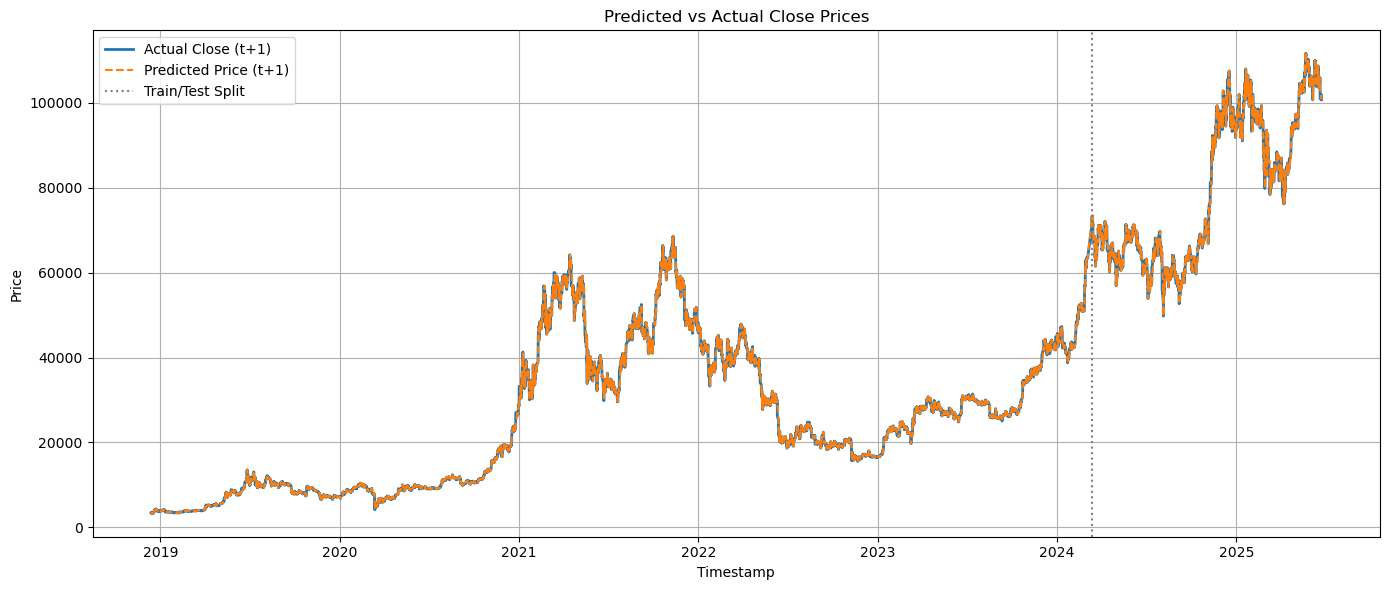

In [48]:
#We're using 20-bar sequences for the model input.
#Batch size for training and inference is 64.
sequence_len = 20
batch_size = 64
#Test set
feature_cols = [
    # Trend we might neeed to remove some of them we can test what is needed and what not
    'ema_short', 'ema_medium', 'ema_long',
    'tema_10', 'tema_21', 'tema_50',
    'slope_tema_10', 'tema_cross_up', 'tema_bullish',
    # Momentum same here
    'macd_diff', 'rsi', 'momentum',  'macd_adx_product',
    # Volatility
    'boll_width', 'atr', 'bollwidth_atr_ratio',
    # Structure & Positioning same here
    'price_range', 'price_vs_range', 
    'close_cross_bb_upper', 'distance_from_ema_long',
    'tema_diff_10_21', 'tema_diff_10_50',
    # Statistical - same
     'regression_slope', 
    # Volume - maybe it is an error to put vol feature and it would be better without it
     'vol_spike',
    # Composite - test needed
    'volatility_direction_ratio', 'trend_consistency', 'tema_trend_strength'
]
#we can try methods (like SHAP or permutation importance) to verify which are most predictive and remove some we do not need
#calc data set features
data = load_historical_data()
df = calculate_features(data)
binary_cols = ['tema_cross_up', 'tema_bullish', 'close_cross_bb_upper', 'vol_spike']
df[feature_cols] = df[feature_cols].copy()  # avoid SettingWithCopyWarning
#we are shiftinc cols to not leak data.
to_shift = [col for col in feature_cols if col not in binary_cols]
df[to_shift] = df[to_shift].shift(1)


# The prediction target is the price delta between now and the next candle future looking.
df['target'] = df['close'].shift(-1) - df['close']
#droping empty places. not destructable as we drop initial rows and one of the end rows because of the change
df.dropna(inplace=True)

#this is used to create some direction to our model that could help it understand the data
#we can experiment without it or with a change of the way we calculate it.
def create_confidence_score(df, method="inverse_atr", atr_col='atr', target_col='target'):
    if method == "inverse_atr":
        df['confidence'] = 1 / (df[atr_col] + 1e-8)
    elif method == "target_magnitude":
        df['confidence'] = df[target_col].abs()
    else:
        raise ValueError("Unsupported method.")

    # Min-max scale to [0, 1]
    df['confidence'] = (df['confidence'] - df['confidence'].min()) / (df['confidence'].max() - df['confidence'].min() + 1e-8)
    return df

df = create_confidence_score(df, method="inverse_atr")
#creating the data sets for test and train not ideal.
#there is no cross validation set we might upgrade and use such
#this way it is just simple.
idx = int(0.8*len(df))
df_train = df[:idx].copy()
df_test = df[idx + sequence_len:].copy()
#scaling the features. 
scaler = StandardScaler()
#apply scale to the features for train and test
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])
df_test[feature_cols] = scaler.transform(df_test[feature_cols])



#creating our sequences for our model
#we did not do it adjustable. but it might be a good idea to be
#so we can change the sequ len and tune it as (hyper param)
#we can also adjust it to remove the confidence score if we would like to not use it
#at the moment we generates 3D array X with shape (samples, 20, num_features)
#Corresponding target y is the price delta at the end of the sequence.
def create_sequence(df):
    X, y, confidence = [], [], []

    for i in range(len(df) - sequence_len):
        x_seq = df.iloc[i : i + sequence_len][feature_cols].values
        y_val = df.iloc[i + sequence_len - 1]['target']
        w_val = df.iloc[i + sequence_len - 1]['confidence']
        X.append(x_seq)
        y.append(y_val)
        confidence.append(w_val)
    return np.array(X),np.array(y),np.array(confidence)

X,y ,confidence = create_sequence(df_train)



#our model with the input shape provide - 3D shp
#Key components:

#Causal Conv1D: Avoids future data, good for fast signal extraction.
#Multi-Head Attention: Transformer-style attention to focus on important parts of the sequence (no future leak).
#LSTM: Captures temporal dependencies.
#Dense: Outputs 1 value (predicted delta).
#Loss is MSE, but the model uses sample_weight=confidence, giving more influence to high-confidence examples.
def build_causal_price_predictor(input_shape):
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense, Conv1D, Add, LayerNormalization, MultiHeadAttention, LSTM, Dropout

    inp = Input(shape=input_shape)

    # Causal convolution: looks only at current and past
    x = Conv1D(32, kernel_size=1, padding='causal', activation='relu')(inp)

    # Transformer-style attention (no future access)
    attn = MultiHeadAttention(num_heads=2, key_dim=32)(x, x, attention_mask=None)
    x = Add()([x, attn])
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)

    # Single-direction LSTM (causal)
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.3)(x)

    # Final linear regression output
    out = Dense(1, activation='linear')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

#Trains the model with internal 20% validation.
#Early stopping ensures we don’t overtrain.
model = build_causal_price_predictor((sequence_len, len(feature_cols)))
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X, y, validation_split=0.2, callbacks=[early_stopping],verbose=1,epochs=10,sample_weight=confidence)

#Outputs predicted price change, not price directly.
predicted_change = model.predict(X, batch_size=batch_size, verbose=1)

predicted_change = predicted_change.flatten()
#Reconstructs the predicted price by adding predicted_change to the last close in the sequence.
# Create prediction DataFrame aligned with last bar in each sequence
df_predictions = pd.DataFrame({
    'timestamp': df.index[sequence_len:sequence_len + len(predicted_change)],
    'current_close': df['close'].iloc[sequence_len:sequence_len + len(predicted_change)].values,
    'predicted_delta': predicted_change,
    'predicted_price': df['close'].iloc[sequence_len:sequence_len + len(predicted_change)].values + predicted_change
})

#Stores the real future close for comparison.
if 'close' in df.columns:
    df_predictions['actual_future_close'] = df['close'].shift(-1).iloc[sequence_len:sequence_len + len(predicted_change)].values


from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(df_predictions['actual_future_close'], df_predictions['predicted_price'])
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_predictions['actual_future_close'], df_predictions['predicted_price'])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((df_predictions['actual_future_close'] - df_predictions['predicted_price']) / df_predictions['actual_future_close'])) * 100
from sklearn.metrics import r2_score
r2 = r2_score(df_predictions['actual_future_close'], df_predictions['predicted_price'])
# Sign agreement: was the direction of change correct?
actual_change = df_predictions['actual_future_close'] - df_predictions['current_close']
predicted_change = df_predictions['predicted_delta']
# Optional: Filter small predicted changes (noise filtering)
threshold = np.std(predicted_change) * 0.5  # or try 1.0 or a fixed value like 5
df_predictions['filtered_signal'] = np.where(
    np.abs(predicted_change) > threshold,
    np.sign(predicted_change),
    0
)

df_predictions['actual_direction'] = np.sign(actual_change)

# Filtered directional accuracy
mask = df_predictions['filtered_signal'] != 0
filtered_accuracy = np.mean(
    df_predictions['filtered_signal'][mask] == df_predictions['actual_direction'][mask]
)
coverage = np.mean(mask)



#% of times the model gets the direction right (sign(pred) == sign(actual_change)).
directional_accuracy = np.mean(np.sign(actual_change) == np.sign(predicted_change))
correlation = df_predictions[['actual_future_close', 'predicted_price']].corr().iloc[0, 1]
df_predictions['abs_error'] = np.abs(df_predictions['predicted_price'] - df_predictions['actual_future_close'])
df_predictions['pct_error'] = 100 * df_predictions['abs_error'] / df_predictions['actual_future_close']
print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")
print(f"Directional Accuracy: {directional_accuracy:.2%}") #tuk sme zle :D ama se pak ne sme clasifier 
print(f"Filtered Directional Accuracy: {filtered_accuracy:.2%}")
#coverage = % of samples that pass the filter
print(f"Signal Coverage: {coverage:.2%}")
print(f"Correlation: {correlation:.4f}")
def create_test_sequence(df, sequence_len, feature_cols):
    X_test, meta_info = [], []
    
    for i in range(len(df) - sequence_len):
        x_seq = df.iloc[i : i + sequence_len][feature_cols].values
        X_test.append(x_seq)
        # Save timestamp and close price at t+sequence_len-1 (where prediction aligns)
        meta_info.append({
            'timestamp': df.iloc[i + sequence_len - 1].name,
            'current_close': df.iloc[i + sequence_len - 1]['close'],
            'actual_future_close': df['close'].shift(-1).iloc[i + sequence_len - 1]
        })

    X_test = np.array(X_test)
    meta_df = pd.DataFrame(meta_info)
    return X_test, meta_df
#Predicts on unseen data (df_test), reconstructs full price.
X_test, meta_df = create_test_sequence(df_test, sequence_len, feature_cols)

# Predict
predicted_change_test = model.predict(X_test, batch_size=batch_size).flatten()

# Add prediction to metadata
meta_df['predicted_delta'] = predicted_change_test
meta_df['predicted_price'] = meta_df['current_close'] + predicted_change_test

combined_df = pd.concat([df_predictions, meta_df], axis=0)
#Visual comparison of actual close vs predicted close.
#Also shows the train/test boundary.
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(combined_df['timestamp'], combined_df['actual_future_close'], label='Actual Close (t+1)', linewidth=2)
plt.plot(combined_df['timestamp'], combined_df['predicted_price'], label='Predicted Price (t+1)', linestyle='--')
plt.axvline(x=meta_df['timestamp'].iloc[0], color='gray', linestyle=':', label='Train/Test Split')
plt.title('Predicted vs Actual Close Prices')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


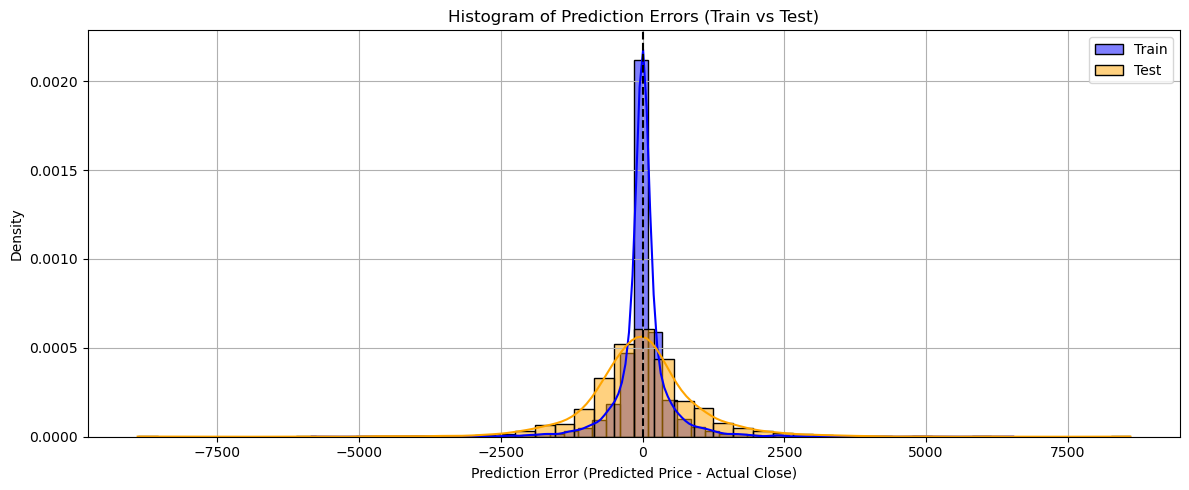

In [147]:
import seaborn as sns
#we visualize and compares prediction errors (residuals) from the train and test datasets.
#Calculate Residuals (Prediction Errors)
#This computes the difference between the model’s predicted price and the true future close.
#Positive error - model overestimated the price.
#Negative error - model underestimated the price.
df_predictions['error'] = df_predictions['predicted_price'] - df_predictions['actual_future_close']
meta_df['error'] = meta_df['predicted_price'] - meta_df['actual_future_close']

#Tails are not too fat (low outliers)
#Similar width ⇒ generalization is good
#Balanced left and right ⇒ equal over/under prediction
#Test > Train width: Overfitting.
#Test mean shifted left/right: Bias on unseen data.
#Fat tails: Model sometimes makes large errors. maybe we would like to do outlier clipping or robust loss.
#Train curve very tight, test very wide: Model memorized training data, poor generalization.
# Plot
plt.figure(figsize=(12, 5))
sns.histplot(df_predictions['error'], color='blue', label='Train', kde=True, stat="density", bins=50)
sns.histplot(meta_df['error'], color='orange', label='Test', kde=True, stat="density", bins=50)
plt.axvline(0, color='black', linestyle='--')
plt.title("Histogram of Prediction Errors (Train vs Test)")
plt.xlabel("Prediction Error (Predicted Price - Actual Close)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


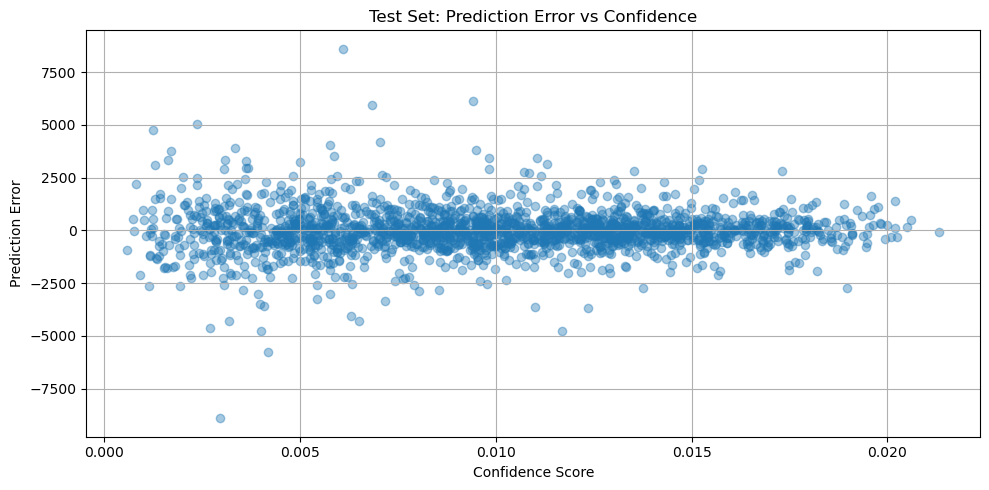

In [149]:
# Add confidence to meta_df if not already present
if 'confidence' in df_test.columns:
    meta_df['confidence'] = df_test['confidence'].iloc[sequence_len:sequence_len + len(meta_df)].values
#This plot is a diagnostic tool to validate whether confidence scores correlate with prediction reliability.
#As confidence increases, errors should decrease
#we should see  - wide spread of errors at low confidence, narrowing toward zero error at high confidence.
# Plot error vs confidence
plt.figure(figsize=(10, 5))
plt.scatter(meta_df['confidence'], meta_df['error'], alpha=0.4)
plt.title("Test Set: Prediction Error vs Confidence")
plt.xlabel("Confidence Score")
plt.ylabel("Prediction Error")
plt.grid(True)
plt.tight_layout()
plt.show()


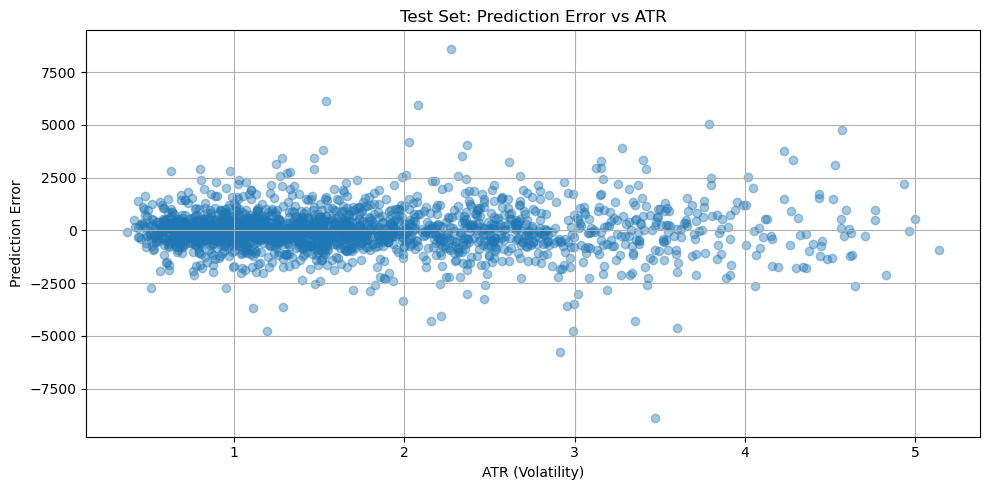

In [150]:
# Add ATR to meta_df
meta_df['atr'] = df_test['atr'].iloc[sequence_len:sequence_len + len(meta_df)].values
#analyze how volatility (ATR) impacts our model's prediction error
#The goal is to see how market volatility affects model reliability.
plt.figure(figsize=(10, 5))
plt.scatter(meta_df['atr'], meta_df['error'], alpha=0.4)
plt.title("Test Set: Prediction Error vs ATR")
plt.xlabel("ATR (Volatility)")
plt.ylabel("Prediction Error")
plt.grid(True)
plt.tight_layout()
plt.show()
#Best result would be funnel like shape with tight errors at low ATR no clear upward trend in high regions model not explode with volatility


In [152]:
# real-time or sequential prediction using trained price delta model.
#This class wraps the trained model, scaler, and features into a real-time inference engine.
#Uses the last N bars (sequence_len) to make predictions.
#Computes a confidence score dynamically based on volatility or predicted movement.
#Filters predictions based on a minimum confidence threshold.
#Allows streaming predictions using predict_all.
#Arguments:
#model: The trained Keras model.  P.S - later on we can create a function to load the model 
#scaler: StandardScaler object fitted to your training set.
#feature_cols: List of features used during training.
#sequence_len: Number of bars to use as input to the model.
#atr_col: Column name for ATR (used for confidence calculation).
#confidence_method: How to compute confidence ("inverse_atr" or "target_magnitude").
#Instructions:
#def fit_confidence_range(self, df_full): must be called once before any prediction to store:
#atr_min and atr_max - used to normalize inverse ATR confidence later.
#def predict(self, df, min_conf=0.0, return_all=False): - single prediction
#Takes the last sequence scales and transforms, calculate the confidence based on selection,applies filter and outputs the prediction.
#On return_all we return a full dictionary else none or just the price - update is needed here for real time system or we will have errors :)
#predict_all() - predicts the whole data set 
#We might need to update it to support more features and tor us to be able to use it on classifier
class RealTimePricePredictor_v1:
    def __init__(self, model, scaler, feature_cols, sequence_len, atr_col='atr', confidence_method="inverse_atr"):
        self.model = model
        self.scaler = scaler
        self.feature_cols = feature_cols
        self.sequence_len = sequence_len
        self.atr_col = atr_col
        self.confidence_method = confidence_method
        self.atr_min = None
        self.atr_max = None

    def fit_confidence_range(self, df_full):
        if self.atr_col not in df_full.columns:
            raise ValueError(f"ATR column '{self.atr_col}' not found in dataframe")
        self.atr_min = df_full[self.atr_col].min()
        self.atr_max = df_full[self.atr_col].max()

    def predict(self, df, min_conf=0.0, return_all=False):
        if len(df) < self.sequence_len:
            raise ValueError(f"Not enough data: required {self.sequence_len}, got {len(df)}")

        if self.atr_min is None or self.atr_max is None:
            raise RuntimeError("ATR range not initialized. Call 'fit_confidence_range(df_full)' first.")

        features = df[self.feature_cols].iloc[-self.sequence_len:]
        features_scaled = self.scaler.transform(features)
        x_input = features_scaled.reshape(1, self.sequence_len, len(self.feature_cols))

        predicted_delta = self.model.predict(x_input, verbose=0)[0, 0]
        last_close = df['close'].iloc[-1]
        predicted_price = last_close + predicted_delta

        if self.confidence_method == "inverse_atr":
            confidence = 1 / (df[self.atr_col].iloc[-1] + 1e-8)
            conf_min = 1 / (self.atr_max + 1e-8)
            conf_max = 1 / (self.atr_min + 1e-8)
        elif self.confidence_method == "target_magnitude":
            confidence = abs(predicted_delta)
            conf_min, conf_max = 0, np.max([abs(predicted_delta), 1e-4])
        else:
            raise ValueError("Unsupported confidence method")

        confidence_scaled = (confidence - conf_min) / (conf_max - conf_min + 1e-8)
        confidence_scaled = np.clip(confidence_scaled, 0, 1)

        if confidence_scaled < min_conf:
            if return_all:
                return {
                    "predicted_price": predicted_price,
                    "predicted_delta": predicted_delta,
                    "last_close": last_close,
                    "confidence": confidence_scaled,
                    "allowed": False
                }
            return None

        if return_all:
            return {
                "predicted_price": predicted_price,
                "predicted_delta": predicted_delta,
                "last_close": last_close,
                "confidence": confidence_scaled,
                "allowed": True
            }

        return predicted_price

    def predict_all(self, df, min_conf=0.0, return_all=True):
        if self.atr_min is None or self.atr_max is None:
            raise RuntimeError("ATR range not initialized. Call 'fit_confidence_range(df_full)' first.")

        predictions = []
        for i in range(self.sequence_len, len(df)):
            sub_df = df.iloc[i - self.sequence_len:i + 1]
            try:
                result = self.predict(sub_df, min_conf=min_conf, return_all=True)
                if result:
                    result['index'] = df.index[i]
                    predictions.append(result)
            except Exception as e:
                print(f"Skipping index {df.index[i]} due to error: {e}")
        return pd.DataFrame(predictions).set_index('index')


In [67]:
#Complete deployment pipeline for using your trained model with real-time logic on historical data (or future streaming data). 
#We are applying the RealTimePricePredictor_v1 class to predict price deltas bar-by-bar, based on a sequence of past features.

# Step 1: Initialize the predictor
#WARNING !!!!! IS THE DATA SET IS VERY BIG YOU WILL WAIT A LOT :) months... years :D soo be carefuf !!!
#AT THE MOMENT NO FUNCTION TO AGGRIGATE THE DATA TO HIGHER TIME FRAME THIS IS TO BE DONE 
#idealy we would like to work with tf with less noise than 1 min so i am using for this setup 4h tf directly from metatrader.
df = load_historical_data()
df = calculate_features(data)
binary_cols = ['tema_cross_up', 'tema_bullish', 'close_cross_bb_upper', 'vol_spike']
df[feature_cols] = df[feature_cols].copy()  # avoid SettingWithCopyWarning

to_shift = [col for col in feature_cols if col not in binary_cols]
df[to_shift] = df[to_shift].shift(1)
df.dropna(inplace=True)
predictor = RealTimePricePredictor_v1(
    model=model,
    scaler=scaler,
    feature_cols=feature_cols,
    sequence_len=sequence_len,
    atr_col='atr',
    confidence_method="inverse_atr"
)

# Step 2: Fit confidence scaling from the full dataset.
#This needs to be done only once !!!! at initialization phase 
#next iterations we do not go through the same steps.
#we do not have a treaded function to check the tf and to load data and to start the predictor and do the predictions
#this is just to initialize the predictions so we can check the data and see if they are ok - so not a complete set up :)
predictor.fit_confidence_range(df)
#df_to_predict = df.tail(100).copy()
# Step 3: Make predictions on the full dataset
results_df = predictor.predict_all(df, min_conf=0.001, return_all=True)
#results_df = predictor.predict(df, min_conf=0.001, return_all=True)

# Step 4: View or analyze the predictions
#print(results_df.head())

#WARNING NOTE : well if you are gonna start this node dont :D forts restart all other nodes and cange the 4h data set to 1 year 
#This is just so you do not wait like 20 min because youll need to predict and label 88k rows and more :)

Calculating features...


In [68]:
results_df

,predicted_price,predicted_delta,last_close,confidence,allowed
index,,,,,
2019-02-12 08:00:00,3615.073028,12.943028,3602.13,0.527126,True
2019-02-12 12:00:00,3628.593047,13.023047,3615.57,0.546461,True
2019-02-12 16:00:00,3630.541072,13.201072,3617.34,0.550063,True
2019-02-12 20:00:00,3627.122790,13.232790,3613.89,0.568416,True
2019-02-13 00:00:00,3644.068531,13.128531,3630.94,0.543790,True
...,...,...,...,...,...
2025-06-23 00:00:00,100898.135696,-5.864304,100904.00,0.010723,True
2025-06-23 04:00:00,101160.452440,-5.547560,101166.00,0.007876,True
2025-06-23 08:00:00,101862.811527,-5.188473,101868.00,0.008327,True


In [69]:
results_df['allowed'].value_counts()

allowed
True     9894
False      20
Name: count, dtype: int64

In [12]:
# only 20 bars are ignored min conf is not configured accordingly to what would be best outcome. that needs to be adjusted
#below is a graphic of the values for min max atr  that we use for the entire data set.
#maybe the approach is bad here and we need to get the min max atr not for the entire data set but create a smaller data set for the purposes of predictions
#in real time and then normalize it. 

20.0021639557878 3372.1549873390986


<Axes: xlabel='timestamp'>

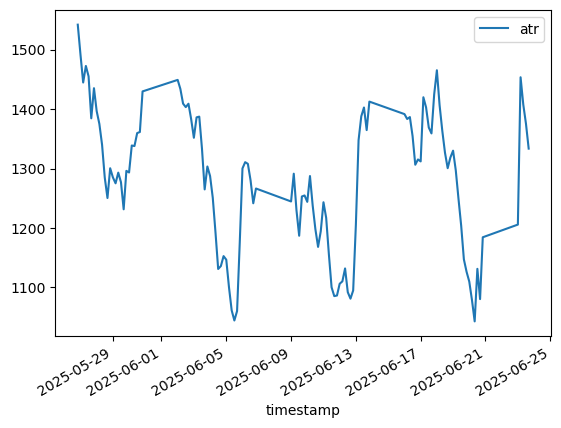

In [70]:
print(predictor.atr_min, predictor.atr_max)
results_df['timestamp'] = df.index[-len(results_df):]  # Restore timestamp
results_df['atr'] = df['atr'].iloc[-len(results_df):].values  # Restore ATR
results_df[['timestamp', 'atr']].tail(120).plot(x='timestamp', y='atr')


<Axes: xlabel='timestamp'>

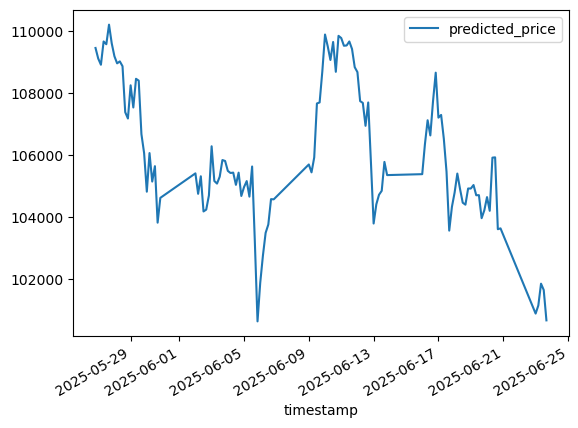

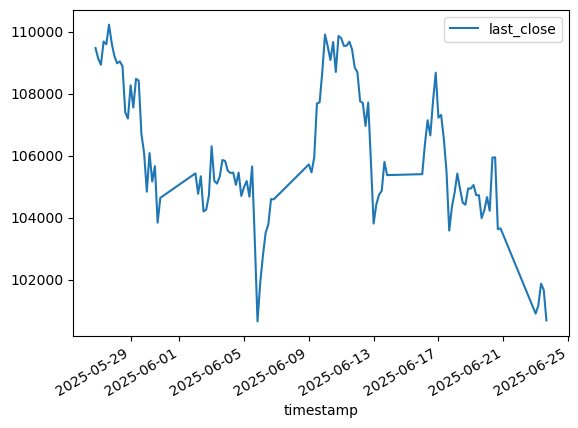

In [71]:
results_df[['timestamp', 'predicted_price']].tail(120).plot(x='timestamp', y='predicted_price')
results_df[['timestamp', 'last_close']].tail(120).plot(x='timestamp', y='last_close')

In [72]:
results_df.tail(20)

,predicted_price,predicted_delta,last_close,confidence,allowed,timestamp,atr
index,,,,,,,
2025-06-18 12:00:00,104474.141674,-5.858326,104480.0,0.009200,True,2025-06-18 12:00:00,1326.708478
2025-06-18 16:00:00,104410.215567,-5.784433,104416.0,0.009505,True,2025-06-18 16:00:00,1300.515015
2025-06-18 20:00:00,104932.122676,-5.877324,104938.0,0.009294,True,2025-06-18 20:00:00,1318.478228
2025-06-19 00:00:00,104931.111588,-5.888412,104937.0,0.009162,True,2025-06-19 00:00:00,1330.015498
2025-06-19 04:00:00,105044.023244,-5.976756,105050.0,0.009548,True,2025-06-19 04:00:00,1296.942962
2025-06-19 08:00:00,104713.938358,-6.061642,104720.0,0.010139,True,2025-06-19 08:00:00,1249.304179
2025-06-19 12:00:00,104717.928872,-6.071128,104724.0,0.010748,True,2025-06-19 12:00:00,1203.782452
2025-06-19 16:00:00,103974.948510,-6.051490,103981.0,0.011574,True,2025-06-19 16:00:00,1147.083705
2025-06-19 20:00:00,104229.991647,-6.008353,104236.0,0.011901,True,2025-06-19 20:00:00,1126.149155


In [73]:
result_df

NameError: name 'result_df' is not defined

In [153]:
#DONT RUN THIS CELL CHECK THE NEXT IT WAS A TEST 
if not(results_df.empty) and results_df["allowed"].iloc[-1]:
    predicted_price = results_df['predicted_price'].iloc[-1]
    prev_val = results_df['last_close'].iloc[-1]
    percent_change = 100 * (predicted_price - prev_val) / prev_val

    print(f"Next price prediction: {predicted_price:.5f} (Confidence: {results_df['confidence'].iloc[-1]:.2f}, Change: {percent_change:.3f}%)")

    if abs(percent_change) < 0.3:
        print("Signal: NEUTRAL (change < 0.3%)")
    elif predicted_price > prev_val:
        print("Signal: BUY")
    elif predicted_price < prev_val:
        print("Signal: SELL")
else:
    print("Low confidence: skipping signal.")
    if pred is not None:
        print(f"Prediction was: {results_df['predicted_price'].iloc[-1]:.5f}, Confidence: {results_df['confidence'].iloc[-1]:.2f}")


Next price prediction: 100679.55635 (Confidence: 0.01, Change: -0.005%)
Signal: NEUTRAL (change < 0.3%)


In [154]:
#Converts the model’s continuous predictions into discrete trading signals: BUY (1), SELL (-1), or NEUTRAL (0). 
#So in short -  we check if prediction is valid if it pass the confidence score,if prediction is not allowed we just turn it to neutral score so 0
#There are some debug prints and some not used calculations as i had something in mind but did not do it yet there will be V1 :)
def calculate_position_label(df,change=0.01):
    labels = list()
    for i in range(0,len(df)):
        print(f'{i} cycle')
        if not(results_df.empty) and results_df["allowed"].iloc[i]:
            predicted_price = results_df['predicted_price'].iloc[i]
            prev_val = results_df['last_close'].iloc[i]
            percent_change = 100 * (predicted_price - prev_val) / prev_val
        
            print(f"Next price prediction: {predicted_price:.5f} (Confidence: {results_df['confidence'].iloc[i]:.2f}, Change: {percent_change:.3f}%)")
        
            if abs(percent_change) < change:
                print("Signal: NEUTRAL (change < 0.3%)")
                labels.append(0)
            elif predicted_price > prev_val:
                print("Signal: BUY")
                labels.append(1)
            elif predicted_price < prev_val:
                print("Signal: SELL")
                labels.append(-1)
        else:
            print("Low confidence: skipping signal.")
            if predicted_price is not None:
                print(f"Prediction was: {results_df['predicted_price'].iloc[i]:.5f}, Confidence: {results_df['confidence'].iloc[i]:.2f}")
                labels.append(0)
    return labels

In [130]:
labels = calculate_position_label(results_df,0.08)

0 cycle
Next price prediction: 3615.07303 (Confidence: 0.53, Change: 0.359%)
Signal: BUY
1 cycle
Next price prediction: 3628.59305 (Confidence: 0.55, Change: 0.360%)
Signal: BUY
2 cycle
Next price prediction: 3630.54107 (Confidence: 0.55, Change: 0.365%)
Signal: BUY
3 cycle
Next price prediction: 3627.12279 (Confidence: 0.57, Change: 0.366%)
Signal: BUY
4 cycle
Next price prediction: 3644.06853 (Confidence: 0.54, Change: 0.362%)
Signal: BUY
5 cycle
Next price prediction: 3651.91602 (Confidence: 0.56, Change: 0.360%)
Signal: BUY
6 cycle
Next price prediction: 3630.57887 (Confidence: 0.58, Change: 0.363%)
Signal: BUY
7 cycle
Next price prediction: 3626.45416 (Confidence: 0.56, Change: 0.352%)
Signal: BUY
8 cycle
Next price prediction: 3626.73250 (Confidence: 0.58, Change: 0.343%)
Signal: BUY
9 cycle
Next price prediction: 3619.08969 (Confidence: 0.60, Change: 0.307%)
Signal: BUY
10 cycle
Next price prediction: 3624.29393 (Confidence: 0.62, Change: 0.192%)
Signal: BUY
11 cycle
Next price 

In [27]:
df.to_csv('btc_1d_db.csv')

In [28]:
df_test.to_csv('btc_1d_db_test.csv')

In [87]:
results_df.to_csv('btc_4h_wp.csv')

In [128]:
results_df['signal_direction'].value_counts()

signal_direction
0    8971
1     943
Name: count, dtype: int64

In [40]:
range(1,len(df)-1)

range(1, 1501)

In [92]:
results_df["allowed"].value_counts()

allowed
True     1421
False      62
Name: count, dtype: int64

In [93]:
results_df.iloc[1481]

predicted_price           104231.35704
predicted_delta               -4.64296
last_close                    104236.0
confidence                    0.032591
allowed                           True
timestamp          2025-06-19 00:00:00
atr                        3295.208873
Name: 2025-06-19 00:00:00, dtype: object

In [94]:
len(results_df)

1483

In [131]:
results_df['signal_direction'] = labels

In [110]:
len(labels)

9914

In [94]:
results_df['signal_direction'].value_counts()

signal_direction
0    8286
1    1628
Name: count, dtype: int64

In [98]:
def calculate_pnl(df):
    ....

SyntaxError: invalid syntax (443214444.py, line 2)

In [155]:
def sortino_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    downside_returns = excess_returns[excess_returns < 0]
    downside_std = np.std(downside_returns, ddof=1)
    
    if downside_std == 0:
        return np.nan  # Avoid division by zero
    
    return np.mean(excess_returns) / downside_std


#sortino_per_asset = df.groupby('asset')['returns'].apply(lambda r: sortino_ratio(r, risk_free_rate=0.0)) maybe we would need this not sure ?
sortino_per_asset = sortino_ratio(df['returns'], risk_free_rate=0.0)


In [100]:
def calculate_sortino_ratio(df, price_column='close', signal_column='signal', risk_free_rate=0.0, annualize=False, periods_per_year=252):
    df = df.copy()

    # Ensure price is float
    df[price_column] = df[price_column].astype(float)

    # Compute forward returns (T+1)
    df['return'] = df[price_column].pct_change().shift(-1)

    # Compute strategy returns
    df['strategy_return'] = df[signal_column] * df['return']

    # Drop missing values
    strategy_returns = df['strategy_return'].dropna()

    # Mean return
    mean_return = strategy_returns.mean()

    # Downside deviation (returns below risk-free rate)
    downside_returns = strategy_returns[strategy_returns < risk_free_rate]
    downside_std = np.std(downside_returns)

    if downside_std == 0:
        return np.nan

    sortino_ratio = (mean_return - risk_free_rate) / downside_std

    if annualize:
        sortino_ratio *= np.sqrt(periods_per_year)
    

    
    return sortino_ratio

In [111]:
calculate_sortino_ratio(results_df,'last_close',signal_column='predicted_price',annualize=True,periods_per_year=356)

NameError: name 'calculate_sortino_ratio' is not defined

In [91]:
import matplotlib.pyplot as plt
#WARNING if you use this code you might need to start from the beginning because the shift in result_df depending ot what you are gonna do next
#Mabybe this should be a def and i copy the data inside just for the plot.
# Shift last_close backwards to align it with predicted_price
results_df['actual_close_t+1'] = results_df['last_close'].shift(-1)

# Drop last row because we don’t have actual close for its prediction
plot_df = df.dropna(subset=['actual_close_t+1'])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df['predicted_price'], label='Predicted Price (for t+1)')
plt.plot(plot_df.index, plot_df['actual_close_t+1'], label='Actual Close (t+1)', linestyle='--')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Predicted vs Actual Close Price at t+1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: ['actual_close_t+1']

In [104]:
plot_df

,predicted_price,predicted_delta,last_close,confidence,allowed,timestamp,atr,signal_direction,actual_close_t+1
index,,,,,,,,,
2019-10-24,7466.321784,28.841784,7437.48,0.575708,True,2019-10-24,413.089693,1,7437.48
2019-10-25,8583.942878,28.832878,8555.11,0.484223,True,2019-10-25,484.465429,1,8555.11
2019-10-27,9632.663235,28.863235,9603.80,0.436366,True,2019-10-27,532.605041,1,9603.80
2019-10-28,9473.830108,28.870108,9444.96,0.427544,True,2019-10-28,542.542539,1,9444.96
2019-10-29,9435.863856,28.893856,9406.97,0.430792,True,2019-10-29,538.840929,1,9406.97
...,...,...,...,...,...,...,...,...,...
2025-06-13,105365.201505,-4.798495,105370.00,0.032072,True,2025-06-13,3317.312387,0,105370.00
2025-06-16,108668.899459,-5.100541,108674.00,0.030293,True,2025-06-16,3395.432931,0,108674.00
2025-06-17,104342.117588,-4.882412,104347.00,0.026914,True,2025-06-17,3554.402007,0,104347.00


In [158]:
import numpy as np
import pandas as pd
#A simple back tester takes a signal-labeled price series and simulates a simple trading strategy, then evaluates its performance with common metrics
#Metrics - if they are correct....
#Profit/loss per trade
#Win rate
#Sharpe & Sortino ratios
#Max win/loss streaks
#Updates.... stop loss take profit cum returns slippage signal delay multi horizon back testing  and etc... 
#Possible error with entry :) i think i mess it up and we enter on close :D not on open price sooooo it should be way more profitable :D
#That to be checed i am a bug :D
def evaluate_signals(df, signal_col='signal_direction', price_col='last_close'):
    df = df.copy()
    df['shifted_signal'] = df[signal_col].shift(1)
    df['position_change'] = df[signal_col] != df['shifted_signal']

    trades = []
    entry_price = None
    entry_type = None
    entry_index = None

    for i in range(1, len(df)):
        prev_sig = df.iloc[i - 1][signal_col]
        curr_sig = df.iloc[i][signal_col]
        curr_price = df.iloc[i][price_col]
        timestamp = df.index[i]

        # Entry signal
        if prev_sig == 0 and curr_sig in [-1, 1]:
            entry_price = curr_price
            entry_type = curr_sig
            entry_index = i

        # Exit signal
        elif entry_price is not None and (
            curr_sig == 0 or (entry_type == 1 and curr_sig == -1) or (entry_type == -1 and curr_sig == 1)
        ):
            exit_price = curr_price
            pnl = (exit_price - entry_price) if entry_type == 1 else (entry_price - exit_price)
            ret_pct = pnl / entry_price
            trades.append({
                'entry_time': df.index[entry_index],
                'exit_time': timestamp,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'type': 'long' if entry_type == 1 else 'short',
                'return': ret_pct
            })
            entry_price = None
            entry_type = None
            entry_index = None

    trades_df = pd.DataFrame(trades)
    if trades_df.empty:
        print("No trades detected.")
        return {}

    returns = trades_df['return']
    mean_return = returns.mean()
    std_return = returns.std()
    downside_std = returns[returns < 0].std()

    sharpe = mean_return / std_return if std_return else 0
    sortino = mean_return / downside_std if downside_std else 0
    total_pnl = returns.sum()
    win_rate = (returns > 0).mean()
    
    # Streaks
    win_streak = max_streak = 0
    curr_streak = 0
    last_result = None
    for r in returns > 0:
        if r == last_result:
            curr_streak += 1
        else:
            curr_streak = 1
        last_result = r
        if r:
            win_streak = max(win_streak, curr_streak)
        else:
            max_streak = max(max_streak, curr_streak)

    metrics = {
        'total_pnl': total_pnl,
        'mean_return': mean_return,
        'sharpe_ratio': sharpe,
        'sortino_ratio': sortino,
        'win_rate': win_rate,
        'max_win_streak': win_streak,
        'max_loss_streak': max_streak,
        'num_trades': len(trades_df)
    }

    return metrics, trades_df


In [53]:
meta_df

,timestamp,current_close,actual_future_close,predicted_delta,predicted_price,error,confidence,atr
0,2024-03-12 12:00:00,72255.0,71029.0,12.725399,72267.725399,1238.725399,0.007792,1.853087
1,2024-03-12 16:00:00,71029.0,70916.0,12.627857,71041.627857,125.627857,0.006058,2.283570
2,2024-03-12 20:00:00,70916.0,71954.0,12.370190,70928.370190,-1025.629810,0.006319,2.211039
3,2024-03-13 00:00:00,71954.0,72120.0,12.293907,71966.293907,-153.706093,0.006443,2.177526
4,2024-03-13 04:00:00,72120.0,73273.0,12.346868,72132.346868,-1140.653132,0.007168,1.994867
...,...,...,...,...,...,...,...,...
1992,2025-06-20 20:00:00,103652.0,100904.0,-5.642021,103646.357979,2742.357979,0.010723,1.328589
1993,2025-06-23 00:00:00,100904.0,101166.0,-5.864305,100898.135695,-267.864305,0.007876,1.834880
1994,2025-06-23 04:00:00,101166.0,101868.0,-5.547563,101160.452437,-707.547563,0.008327,1.741162
1995,2025-06-23 08:00:00,101868.0,101665.0,-5.188472,101862.811528,197.811528,0.008664,1.674995


In [112]:
metrics, trades = evaluate_signals(results_df)

In [113]:
trades

,entry_time,exit_time,entry_price,exit_price,type,return
0,2019-02-18 04:00:00,2019-02-22 08:00:00,3713.26,3960.30,long,0.066529
1,2019-02-27 04:00:00,2019-02-27 20:00:00,3842.13,3781.02,long,-0.015905
2,2019-02-28 04:00:00,2019-02-28 08:00:00,3847.60,3860.36,long,0.003316
3,2019-03-05 16:00:00,2019-03-08 12:00:00,3876.27,3921.44,long,0.011653
4,2019-03-08 16:00:00,2019-03-08 20:00:00,3927.45,3911.75,long,-0.003998
...,...,...,...,...,...,...
76,2020-11-04 20:00:00,2020-11-10 12:00:00,14016.00,15302.00,long,0.091752
77,2020-11-12 12:00:00,2020-11-13 00:00:00,15991.00,16420.00,long,0.026828
78,2020-11-13 04:00:00,2020-11-13 08:00:00,16222.00,16311.00,long,0.005486
79,2020-11-13 12:00:00,2020-11-13 16:00:00,16220.00,16245.00,long,0.001541


In [114]:
metrics

{'total_pnl': 2.2543889425822257,
 'mean_return': 0.02783196225410155,
 'sharpe_ratio': 0.3673155188126233,
 'sortino_ratio': 1.8573237026043883,
 'win_rate': 0.5432098765432098,
 'max_win_streak': 9,
 'max_loss_streak': 6,
 'num_trades': 81}

In [159]:
#Same as before just with portfolio test...
#And maybe with the same bug :D coz copy/paste :D

def evaluate_signals_portfolio(df, signal_col='signal_direction', price_col='last_close', starting_capital=10_000, risk_pct=0.01):
    df = df.copy()
    df['shifted_signal'] = df[signal_col].shift(1)

    trades = []
    capital = starting_capital
    equity_curve = [capital]

    entry_price = None
    entry_type = None
    entry_index = None

    for i in range(1, len(df)):
        prev_sig = df.iloc[i - 1][signal_col]
        curr_sig = df.iloc[i][signal_col]
        curr_price = df.iloc[i][price_col]
        timestamp = df.index[i]

        if prev_sig == 0 and curr_sig in [-1, 1]:
            entry_price = curr_price
            entry_type = curr_sig
            entry_index = i

        elif entry_price is not None and (
            curr_sig == 0 or (entry_type == 1 and curr_sig == -1) or (entry_type == -1 and curr_sig == 1)
        ):
            exit_price = curr_price
            direction = 1 if entry_type == 1 else -1
            return_pct = (exit_price - entry_price) / entry_price * direction

            trade_capital = capital * risk_pct
            pnl = trade_capital * return_pct
            capital += pnl
            equity_curve.append(capital)

            trades.append({
                'entry_time': df.index[entry_index],
                'exit_time': timestamp,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'type': 'long' if entry_type == 1 else 'short',
                'return_pct': return_pct,
                'pnl': pnl,
                'capital_after': capital
            })

            entry_price = None
            entry_type = None
            entry_index = None

    trades_df = pd.DataFrame(trades)
    if trades_df.empty:
        print("No trades executed.")
        return {}, pd.DataFrame(), pd.Series(equity_curve)

    returns = trades_df['pnl']
    mean_return = returns.mean()
    std_return = returns.std()
    downside_std = returns[returns < 0].std()
    sharpe = mean_return / std_return if std_return else 0
    sortino = mean_return / downside_std if downside_std else 0
    total_pnl = capital - starting_capital
    win_rate = (trades_df['pnl'] > 0).mean()

    # Streaks
    win_streak = loss_streak = curr_streak = 0
    last_win = None
    for r in trades_df['pnl'] > 0:
        if r == last_win:
            curr_streak += 1
        else:
            curr_streak = 1
        if r:
            win_streak = max(win_streak, curr_streak)
        else:
            loss_streak = max(loss_streak, curr_streak)
        last_win = r

    metrics = {
        'final_capital': capital,
        'total_pnl': total_pnl,
        'mean_pnl_per_trade': mean_return,
        'sharpe_ratio': sharpe,
        'sortino_ratio': sortino,
        'win_rate': win_rate,
        'max_win_streak': win_streak,
        'max_loss_streak': loss_streak,
        'num_trades': len(trades_df)
    }

    return metrics, trades_df, pd.Series(equity_curve, name='Equity Curve')


{'final_capital': 10227.732702631352, 'total_pnl': 227.73270263135237, 'mean_pnl_per_trade': 2.8115148473006126, 'sharpe_ratio': 0.3679595637867696, 'sortino_ratio': 1.8485662124823363, 'win_rate': 0.5432098765432098, 'max_win_streak': 9, 'max_loss_streak': 6, 'num_trades': 81}


<Axes: title={'center': 'Equity Curve'}>

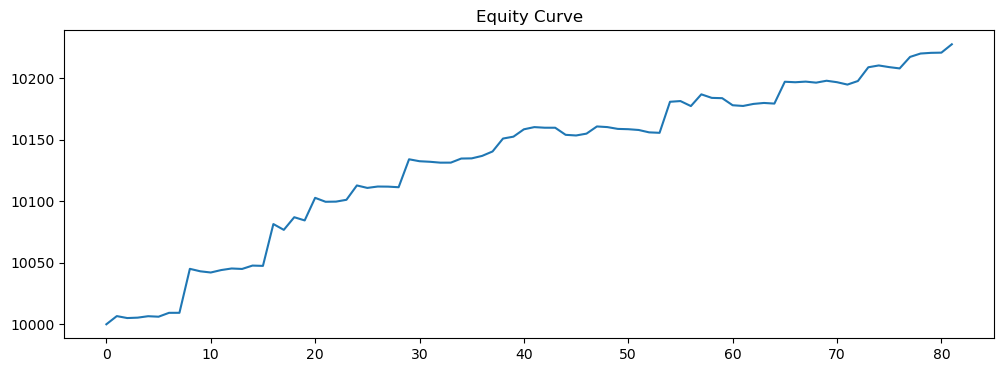

In [119]:
metrics, trades_df, equity = evaluate_signals_portfolio(results_df, signal_col='signal_direction', price_col='last_close')
print(metrics)
equity.plot(title="Equity Curve", figsize=(12,4))


In [120]:
results_df

,predicted_price,predicted_delta,last_close,confidence,allowed,timestamp,atr,signal_direction,actual_close_t+1
index,,,,,,,,,
2019-02-12 08:00:00,3615.073028,12.943028,3602.13,0.527126,True,2019-02-12 08:00:00,37.744851,1,3615.57
2019-02-12 12:00:00,3628.593047,13.023047,3615.57,0.546461,True,2019-02-12 12:00:00,36.423790,1,3617.34
2019-02-12 16:00:00,3630.541072,13.201072,3617.34,0.550063,True,2019-02-12 16:00:00,36.187805,1,3613.89
2019-02-12 20:00:00,3627.122790,13.232790,3613.89,0.568416,True,2019-02-12 20:00:00,35.031534,1,3630.94
2019-02-13 00:00:00,3644.068531,13.128531,3630.94,0.543790,True,2019-02-13 00:00:00,36.600710,1,3638.81
...,...,...,...,...,...,...,...,...,...
2025-06-23 00:00:00,100898.135696,-5.864304,100904.00,0.010723,True,2025-06-23 00:00:00,1205.607837,0,101166.00
2025-06-23 04:00:00,101160.452440,-5.547560,101166.00,0.007876,True,2025-06-23 04:00:00,1453.557277,0,101868.00
2025-06-23 08:00:00,101862.811527,-5.188473,101868.00,0.008327,True,2025-06-23 08:00:00,1407.660329,0,101665.00


In [160]:
#Well same with the same bug.... to be fixed
#Yeah it is not a bug prev cose is new bar open so it should be fine
def evaluate_signals_portfolio_v1(df, signal_col='signal_direction', price_col='last_close', starting_capital=10_000, risk_pct=0.01):
    df = df.copy()
    df['shifted_signal'] = df[signal_col].shift(1)

    trades = []
    capital = starting_capital
    equity_curve = []
    failure_flag = False
    failure_index = None

    entry_price = None
    entry_type = None
    entry_index = None

    for i in range(1, len(df)):
        prev_sig = df.iloc[i - 1][signal_col]
        curr_sig = df.iloc[i][signal_col]
        curr_price = df.iloc[i][price_col]
        timestamp = df.index[i]

        if prev_sig == 0 and curr_sig in [-1, 1]:
            entry_price = curr_price
            entry_type = curr_sig
            entry_index = i

        elif entry_price is not None and (
            curr_sig == 0 or (entry_type == 1 and curr_sig == -1) or (entry_type == -1 and curr_sig == 1)
        ):
            exit_price = curr_price
            direction = 1 if entry_type == 1 else -1
            return_pct = (exit_price - entry_price) / entry_price * direction

            trade_capital = capital * risk_pct
            pnl = trade_capital * return_pct
            capital += pnl
            equity_curve.append((timestamp, capital))

            trades.append({
                'entry_time': df.index[entry_index],
                'exit_time': timestamp,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'type': 'long' if entry_type == 1 else 'short',
                'return_pct': return_pct,
                'pnl': pnl,
                'capital_after': capital
            })

            if not failure_flag and capital < 0.5 * starting_capital:
                failure_flag = True
                failure_index = timestamp  # or i if you want the row index

            entry_price = None
            entry_type = None
            entry_index = None

    trades_df = pd.DataFrame(trades)

    # Build equity curve series aligned to df
    equity_series = pd.Series(index=df.index, dtype=float)
    for ts, cap in equity_curve:
        equity_series.loc[ts] = cap
    equity_series.ffill(inplace=True)
    equity_series.fillna(method='bfill', inplace=True)

    # Add failure annotation column
    df['strategy_status'] = None
    if failure_flag:
        df.loc[df.index >= failure_index, 'strategy_status'] = "Strategy Unsuccessful (Capital < 50%)"

    if trades_df.empty:
        print("No trades executed.")
        return {}, pd.DataFrame(), equity_series, df

    returns = trades_df['pnl']
    mean_return = returns.mean()
    std_return = returns.std()
    downside_std = returns[returns < 0].std()
    sharpe = mean_return / std_return if std_return else 0
    sortino = mean_return / downside_std if downside_std else 0
    total_pnl = capital - starting_capital
    win_rate = (returns > 0).mean()

    # Streaks
    win_streak = loss_streak = curr_streak = 0
    last_win = None
    for r in returns > 0:
        if r == last_win:
            curr_streak += 1
        else:
            curr_streak = 1
        if r:
            win_streak = max(win_streak, curr_streak)
        else:
            loss_streak = max(loss_streak, curr_streak)
        last_win = r

    metrics = {
        'final_capital': capital,
        'total_pnl': total_pnl,
        'mean_pnl_per_trade': mean_return,
        'sharpe_ratio': sharpe,
        'sortino_ratio': sortino,
        'win_rate': win_rate,
        'max_win_streak': win_streak,
        'max_loss_streak': loss_streak,
        'num_trades': len(trades_df),
        'failure_triggered': failure_flag,
        'failure_timestamp': failure_index
    }

    return metrics, trades_df, equity_series, df


C:\Users\Sit\AppData\Local\Temp\ipykernel_7992\1204572827.py:64: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  equity_series.fillna(method='bfill', inplace=True)


{'final_capital': 36715.97768990319, 'total_pnl': 26715.977689903193, 'mean_pnl_per_trade': 63.45837931093394, 'sharpe_ratio': 0.14058950269212395, 'sortino_ratio': 0.3866073395657012, 'win_rate': 0.44418052256532065, 'max_win_streak': 9, 'max_loss_streak': 7, 'num_trades': 421, 'failure_triggered': False, 'failure_timestamp': None}
           entry_time           exit_time  entry_price  exit_price   type  \
0 2019-02-15 00:00:00 2019-02-18 00:00:00      3606.36     3681.31  short   
1 2019-02-25 04:00:00 2019-02-25 20:00:00      3816.97     3843.25  short   
2 2019-02-26 00:00:00 2019-02-26 04:00:00      3855.27     3831.12  short   
3 2019-02-26 08:00:00 2019-02-26 12:00:00      3825.79     3827.41  short   
4 2019-02-26 16:00:00 2019-02-28 16:00:00      3835.76     3833.31   long   

   return_pct        pnl  capital_after  
0   -0.020783 -51.956821    9948.043179  
1   -0.006885 -17.123175    9930.920005  
2    0.006264  15.552200    9946.472205  
3   -0.000423  -1.052938    9945.4

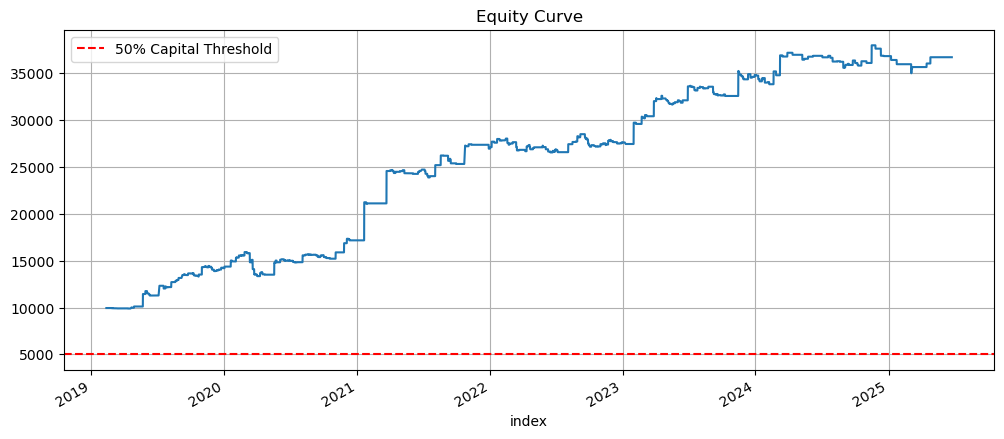

Empty DataFrame
Columns: [strategy_status]
Index: []


In [132]:
metrics, trades_df, equity_curve, df_with_status = evaluate_signals_portfolio_v1(
    results_df,
    signal_col='signal_direction',
    price_col='last_close',
    starting_capital=10_000,
    risk_pct=0.25  
)
# Print key metrics
print(metrics)

# View the first few trades
print(trades_df.head())

# Plot the equity curve
import matplotlib.pyplot as plt

equity_curve.plot(title='Equity Curve', figsize=(12, 5))
plt.axhline(10_000 * 0.5, color='red', linestyle='--', label='50% Capital Threshold')
plt.legend()
plt.grid(True)
plt.show()
# See where the strategy was marked unsuccessful
failure_rows = df_with_status[df_with_status['strategy_status'].notnull()]
print(failure_rows[['strategy_status']].head())



In [133]:
running_max = equity_curve.cummax()
drawdown = equity_curve / running_max - 1
max_drawdown = drawdown.min()

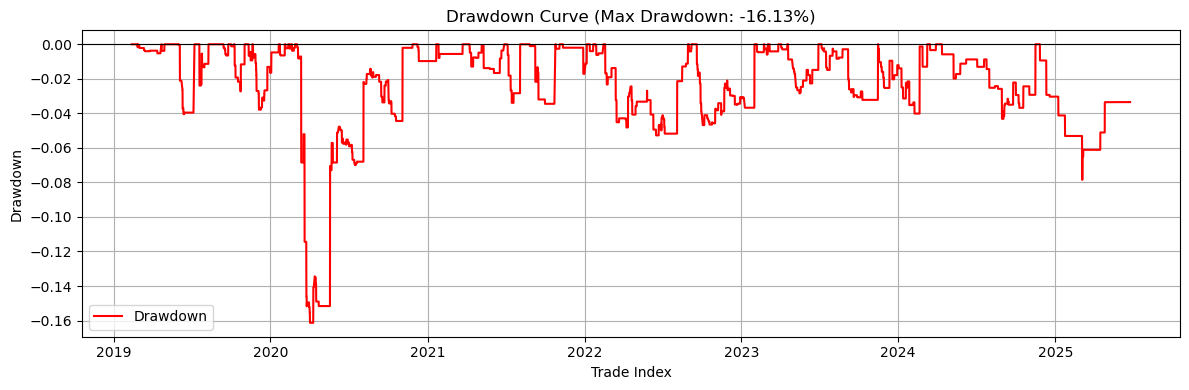

In [134]:
plt.figure(figsize=(12, 4))
plt.plot(drawdown, label='Drawdown', color='red')
plt.title(f"Drawdown Curve (Max Drawdown: {max_drawdown:.2%})")
plt.xlabel("Trade Index")
plt.ylabel("Drawdown")
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [135]:
#soooo it is high risk high rewar system . we have low sharp ratio 

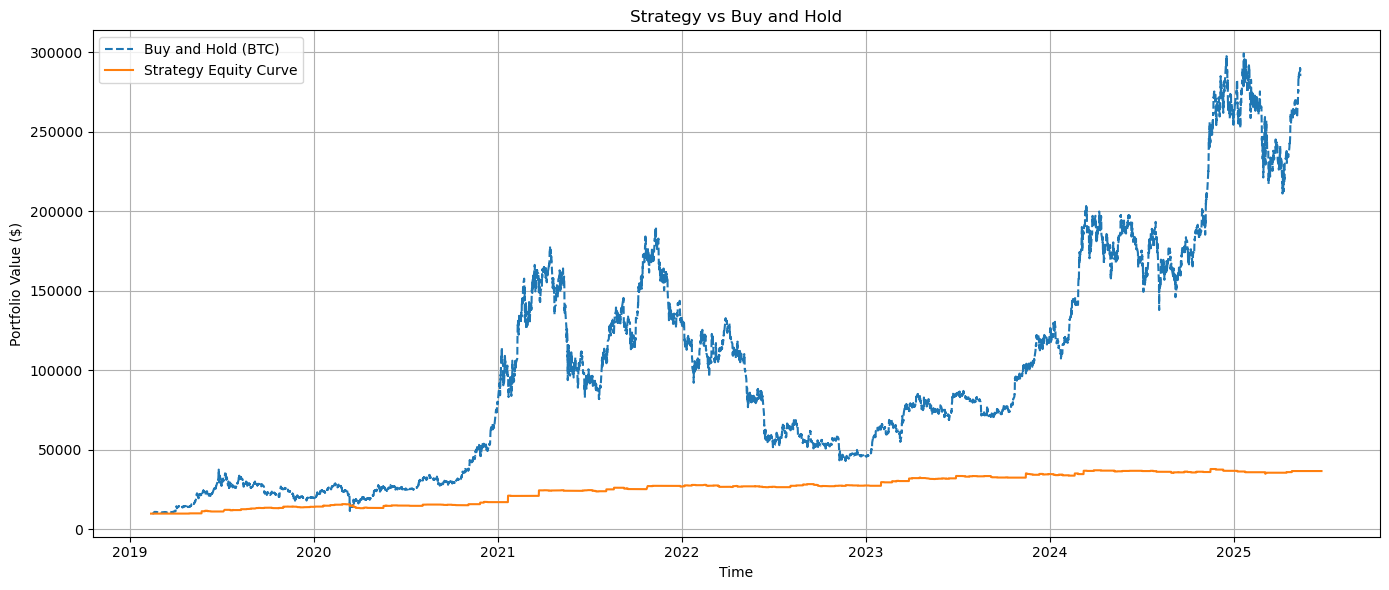

In [136]:
entry_time = trades_df.iloc[0]['entry_time']
final_time = trades_df.iloc[-1]['exit_time']

# Filter the original price series to match the trading period
df_filtered = df_with_status[(df_with_status.index >= entry_time) & (df_with_status.index <= final_time)].copy()

# Assume 'last_close' is the closing price of BTC
start_price = df_filtered['last_close'].iloc[0]
btc_quantity = 10000 / start_price
df_filtered['buy_and_hold_value'] = btc_quantity * df_filtered['last_close']

# Plot both equity curves
plt.figure(figsize=(14, 6))
plt.plot(df_filtered.index, df_filtered['buy_and_hold_value'], label='Buy and Hold (BTC)', linestyle='--')
plt.plot(equity_curve.index, equity_curve.values, label='Strategy Equity Curve')
plt.title("Strategy vs Buy and Hold")
plt.xlabel("Time")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [137]:
#buy and hold is way more profitable giving the situation

In [138]:
#what if we risk more like 75 %  on trade ?

C:\Users\Sit\AppData\Local\Temp\ipykernel_7992\1204572827.py:64: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  equity_series.fillna(method='bfill', inplace=True)


{'final_capital': 307403.7219636689, 'total_pnl': 297403.7219636689, 'mean_pnl_per_trade': 706.4221424315181, 'sharpe_ratio': 0.10071324147476662, 'sortino_ratio': 0.214087707081924, 'win_rate': 0.44418052256532065, 'max_win_streak': 9, 'max_loss_streak': 7, 'num_trades': 421, 'failure_triggered': False, 'failure_timestamp': None}
           entry_time           exit_time  entry_price  exit_price   type  \
0 2019-02-15 00:00:00 2019-02-18 00:00:00      3606.36     3681.31  short   
1 2019-02-25 04:00:00 2019-02-25 20:00:00      3816.97     3843.25  short   
2 2019-02-26 00:00:00 2019-02-26 04:00:00      3855.27     3831.12  short   
3 2019-02-26 08:00:00 2019-02-26 12:00:00      3825.79     3827.41  short   
4 2019-02-26 16:00:00 2019-02-28 16:00:00      3835.76     3833.31   long   

   return_pct         pnl  capital_after  
0   -0.020783 -155.870462    9844.129538  
1   -0.006885  -50.832936    9793.296601  
2    0.006264   46.010029    9839.306630  
3   -0.000423   -3.124781    983

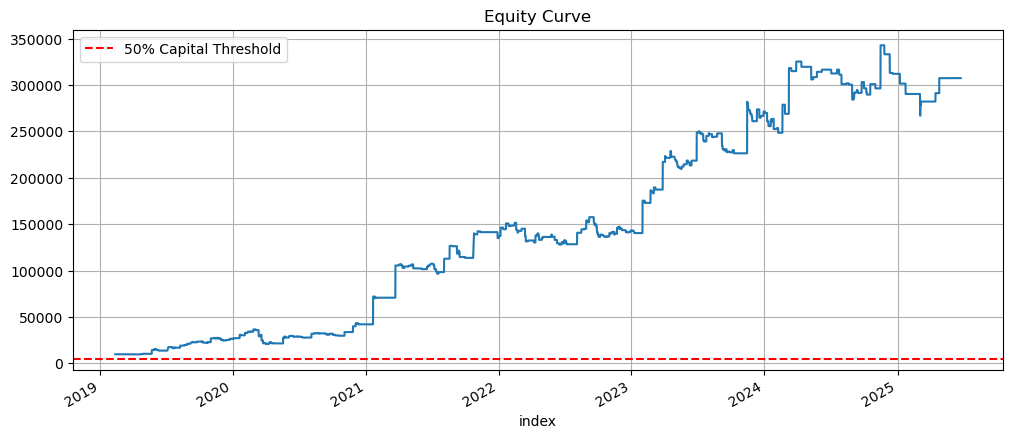

Empty DataFrame
Columns: [strategy_status]
Index: []


In [139]:
metrics, trades_df, equity_curve, df_with_status = evaluate_signals_portfolio_v1(
    results_df,
    signal_col='signal_direction',
    price_col='last_close',
    starting_capital=10_000,
    risk_pct=0.75  # risk 1% per trade
)
# Print key metrics
print(metrics)

# View the first few trades
print(trades_df.head())

# Plot the equity curve
import matplotlib.pyplot as plt

equity_curve.plot(title='Equity Curve', figsize=(12, 5))
plt.axhline(10_000 * 0.5, color='red', linestyle='--', label='50% Capital Threshold')
plt.legend()
plt.grid(True)
plt.show()
# See where the strategy was marked unsuccessful
failure_rows = df_with_status[df_with_status['strategy_status'].notnull()]
print(failure_rows[['strategy_status']].head())



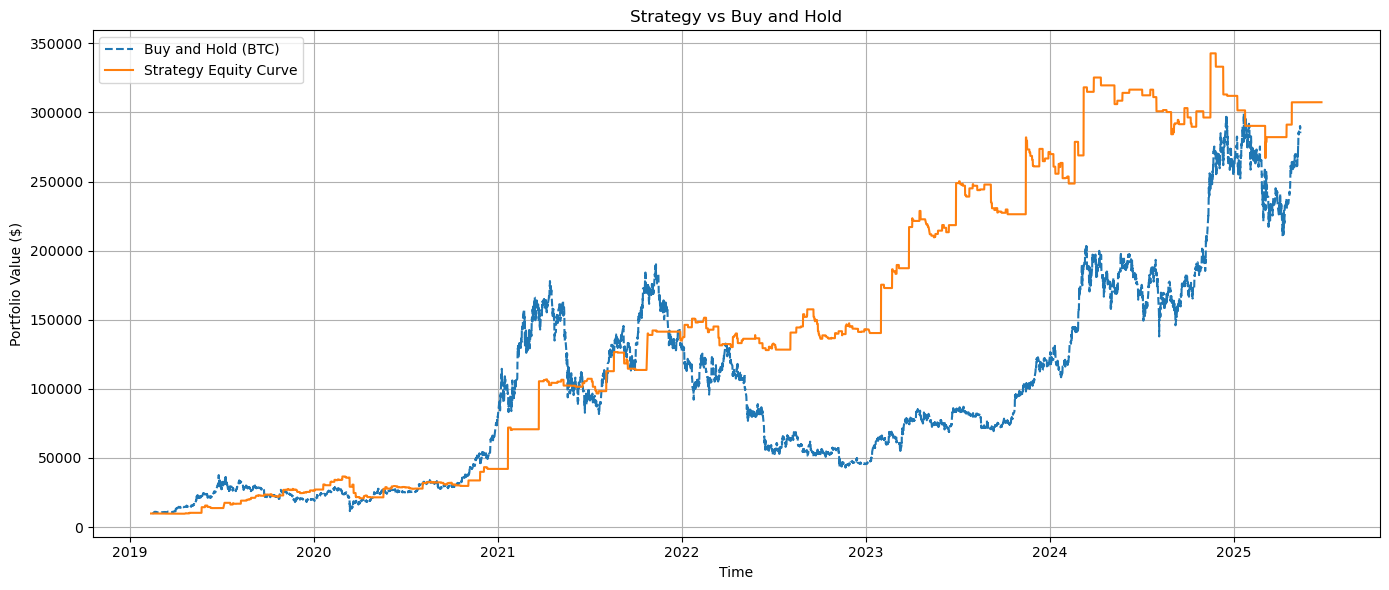

In [140]:
entry_time = trades_df.iloc[0]['entry_time']
final_time = trades_df.iloc[-1]['exit_time']

# Filter the original price series to match the trading period
df_filtered = df_with_status[(df_with_status.index >= entry_time) & (df_with_status.index <= final_time)].copy()

# Assume 'last_close' is the closing price of BTC
start_price = df_filtered['last_close'].iloc[0]
btc_quantity = 10000 / start_price
df_filtered['buy_and_hold_value'] = btc_quantity * df_filtered['last_close']

# Plot both equity curves
plt.figure(figsize=(14, 6))
plt.plot(df_filtered.index, df_filtered['buy_and_hold_value'], label='Buy and Hold (BTC)', linestyle='--')
plt.plot(equity_curve.index, equity_curve.values, label='Strategy Equity Curve')
plt.title("Strategy vs Buy and Hold")
plt.xlabel("Time")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [142]:
#so our strategy is super risky. almost hitted 50% loss but outperformed buy and hold
#if we use stoploss something that we did not do maybe it would be even more profitable

In [143]:
running_max = equity_curve.cummax()
drawdown = equity_curve / running_max - 1
max_drawdown = drawdown.min()

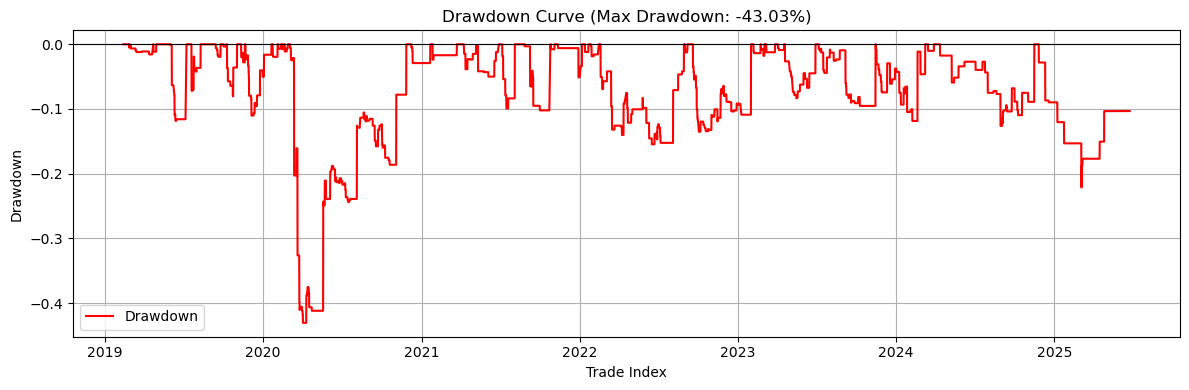

In [144]:
plt.figure(figsize=(12, 4))
plt.plot(drawdown, label='Drawdown', color='red')
plt.title(f"Drawdown Curve (Max Drawdown: {max_drawdown:.2%})")
plt.xlabel("Trade Index")
plt.ylabel("Drawdown")
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#todo

    #what i am missing ? what i am doing wrong? how i can do it better? do i have logical errors? do i have leaking data?  some chat gpt involvement(some checks already done some leaks removed).     
    #ema 50 test  or dema tema or crossings ?
    #stochastic test
    #crossings test
    #macd d+ and - test
    #my trend detection function test(should i ?)
    #hyper param tuning test 
    #portfolio test
    #global resume function for portfolio management test - how ?? do we do it with simple logic or another ai ?
        #global close on 4% win of portfolio per day  as tp ?
        #global loss per day watcher ?
    #time trade cycles ? seasons 
    #black swan even detection and retraining ?
    #global target per month ? 
    #global turnoff on error or sl hit for period of time ?
    #enter in asset when sortino is high and sharp is high ?
    #what risk we should take if we have a global manager ? to be analysed by a model ? so we can decide on what sharp and what sortino it would be the optimal entry ? and if it will be 
    #actually profitable
    #should we switch to classification model insead of price prediction and labeling ?
    #classification will have way better outcome but it is in contrast with what is required from us ? or the price prediction is jsut phase 1 and phase 2 can be classifier ?
    #P.S already have a working classifier that can be adopted for any asset (can provide simple target not the complex tuned one, simpler model no encoding or focal loss no transformer)
    #models predictor switching by global model ? 
    #do we need ranging model and trending model depending on market conditions or we do it with a single model(single simpler) ?
    #do we create voting meta model for sub nn models that are trained on on different part of the the market - one model for buy one for sell one for neutral(already have woring model can provie simple un tunned target not the multi target multi time frame with multi confidence) ?
    #when phase 1 is ready how to do the trader logic ?
        #tread for the global setter that will check where to enter and where not so it can add/remove asset on the fly and check if there are deals for removed asset and close them ?
        #tread for sub data feeds per asset so we can do predictions cannot take globally the data? or if we have more than 5 assets dont know the limit (depending on hardware as well)
        #maybe siple single instance loop that we can ask for several assets at the same time (slower response per asset try to do it in a signle api call)
        #what platform we are gonna use? sceleton for binance bybit and other already done - not with me :D will take time, metatrader easy no all assets and they are against usd and big price spread bigger than crypto platform might decrease performance but ok for presentation
        #maybe just a simpler version just add the assets at the start manually we check for some market params if we are gonna put the asset in the loop or put it without check (checks done only by predictor at instance for the asset)?
        

